# 훈련 노하우

### 검증 세트를 나누고 전처리하는 과정

In [1]:
#로지스틱 회귀로 모델 훈련하고 평가하기
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

- loss와 같은 매개 변수는 가중치나 절편처럼 학습되는 것이 아님
- 사용자가 직접 선택하는 것, 이를 하이퍼파라미터라고 함

In [2]:
#서포트 벡터 머신으로 모델 훈련하고 평가하기
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'hinge', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

- loss = 'hinge'로 지정하여 선형 서포트 벡터 머신(SVM) 문제를 푸는 모델 만듦
- SVM이란 훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업
- loss의 매개변수를 'log'와 'hinge'로 바꾸는 작업, 즉 하이퍼파라미터를 바꾸는 작업을 '모델을 튜닝한다'고 함

테스트세트로 모델을 튜닝하면
- 테스트세트의 정보가 모델에 새어나가게 되어 모델의 일반화 성능이 왜곡됨
- 다른 말로 '낙관적으로 성능을 추정하게 됨'
- 이를 개선하기 위해 검증 세트를 준비함
    - 검증 세트란 모델을 튜닝하기 위한 용도로, 훈련 세트를 조금 떼어 만듦
    - 훈련세트 : 검증세트 : 테스트세트 = 60 : 20 : 20

In [3]:
#전체 데이터 세트를 훈련, 검증, 테스트 세트로 나눔
#이미 8:2로 나눈 데이터를 또 한 번 같은 비율로 나눔
#즉 y_train_all의 비율과 같은 비율로 나눔(stratify=y_train_all )

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [4]:
#검증 세트 사용해 모델 평가하기
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

-> 떨어진 정확도
- 이처럼 데이터 양이 너무 적은 경우에는 검증 세트를 나누지 않고 교차 검증 방법을 사용함
- 대량의 데이터 처리에서
   - 일반적으로 10만개 데이터라면 8 : 1 : 1로 분할함
   - 100만개 이상의 데이터는 98 : 1 : 1로 분할함
- 검증과 테스트 세트의 샘플 수를 1만 개 이상 확보 가능시 훈련 세트에 많은 샘플을 할당하는 것이 좋음


- 데이터가 누락되거나 형태가 균일하지 않을 경우 -> 전처리가 필요함
- 또는 스케일이 다른 경우 -> 또한 전처리가 필요함
    - 특히 경사하강법과 같이 스케일에 민감한 알고리즘에서

### 스케일을 조정하지 않고 모델을 훈련함

['mean perimeter' 'mean area']


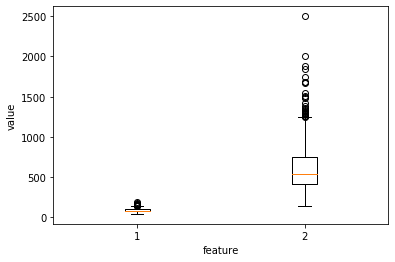

In [29]:
#스케일을 조정하지 않고 모델을 훈련한 경우
from matplotlib import pyplot as plt

print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [6]:
#가중치를 기록할 변수와 학습률 파라미터 추가하기
#SingleLayer 클래스에 인스턴스 변수를 추가하여 에포크마다 가중치의 값을 저장함
class SingleLayer:
    def __init__(self, learning_rate = 0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate

- learning_rate 값으로 가중치의 업데이트 양을 조절할 것
- 가중치의 변화를 안정적으로 하여 -> 전역 최소값에 잘 도달하고, 지나치지 않도록
- 보통 로그 스케일로 학습률을 지정하여 테스트함 (0.001, 0.01)

In [7]:
#가중치를 기록하고 업데이트 양 조절하기
class SingleLayer:
    def fit(self, x, y, epochs = 100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) #가중치의 값이 바뀔 때마다 복사하여 어펜드
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= self.lr * w_grad
                self.w_history.append(self.w.copy())
                a = np.clip(1e-10, 1-1e-10)
                loss += -(y[i] * np.log(a) + (1-y[i]) * np.log(1-a))
            self.losses.append(loss / len(y))

In [8]:
#모델 훈련하고 평가하기
import numpy as np
class SingleLayer:
    def __init__(self, learning_rate = 0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x* err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def fit(self, x, y, epochs = 100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy()) #가중치의 값이 바뀔 때마다 복사하여 어펜드
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= self.lr * w_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i] * np.log(a) + (1-y[i]) * np.log(1-a))
            self.losses.append(loss / len(y))
            
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [9]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

-> w_history에는 100번의 에포크 동안 변경된 가중치가 모두 기록됨
- 이 때 w[2], w[3]의 요소로 그래프를 그리면 아래와 같음
    - 점은 최종으로 결정된 가중치를 의미

<function matplotlib.pyplot.show(*args, **kw)>

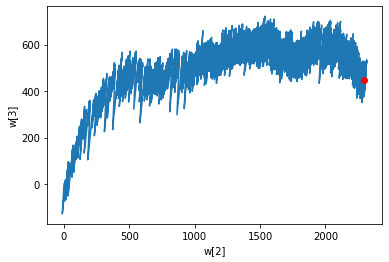

In [10]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro') #최종으로 결정된 가중치
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show

-> w2에 비해 w3의 스케일이 크므로, 학습 과정에서 큰 폭으로 변화함
- 다시 말해 w3에 대한 그레디언트가 크기 때문에 w3 축을 따라 가중치가 크게 요동침
- 즉 가중치의 최적값에 도달하는 동안 w3의 모델이 불안정하게 수렴함

### 스케일을 조정하여 모델을 훈련함

#### 1. 표준화

- 특성값에서 평균을 빼고 표준 편차로 나눔
- 표준화를 통해 평균이 0이고 분산이 1인 특성이 만들어짐

In [11]:
#표준화를 위한 StandardScaler클래스가 사이킷 런에 이미 준비되어 있음

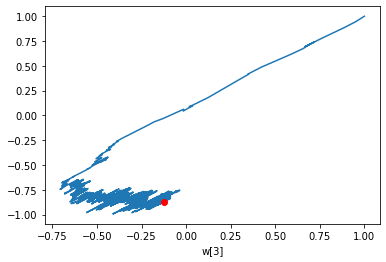

0.37362637362637363

In [12]:
#하지만 넘파이로 표준화 구현
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)
x_train_scaled = (x_train - train_mean) / train_std

layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro') #최종으로 결정된 가중치
plt.xlabel('w[2]')
plt.xlabel('w[3]')
plt.show()

layer2.score(x_val, y_val)

-> 검증세트의 스케일을 변경하지 않았기 때문에 성능이 현저히 떨어짐
- 이전과 비교해 개선된 점은 w2와 w3의 변화 비율이 비슷한 것
- 대각선 방향으로 가중치가 이동하고
- 최적값에 빠르게 근접하고 있음
- 이처럼 경사 하강법에서는 서로 다른 특성의 스케일을 맞추는 것이 중요

In [13]:
#검증세트도 표준화 전처리 적용
val_mean = np.mean(x_val, axis = 0)
val_std = np.std(x_val, axis = 0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

-> 하지만 훈련 세트와 검증 세트를 각가 다른 비율로 전처리를 하여, 훈련 세트와 검증 세트가 각각 다른 비율로 변환된 문제가 발생 (원본 vs 검증세트 산점도, 전처리 vs 검증세트 산점도를 비교하여 알 수 있음)

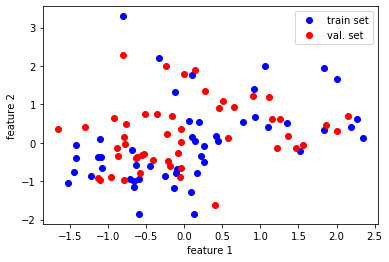

0.967032967032967

In [14]:
#검증 세트를 훈련 세트와 같은 비율로 전처리함 (O)
#즉 훈련 세트의 평균, 표준 편차를 사용하여 검증 세트를 변환함
x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50,0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50,0], x_val_scaled[:50,1], 'ro')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend(['train set', 'val. set'])
plt.show()

layer2.score(x_val_scaled, y_val)

#### 정리하면
- 모델을 튜닝할 때는 테스트세트 대신 검증 세트 사용
- 데이터를 전처리 할 때는 훈련 세트의 통계값으로 검증세트와 테스트 세트를 변환해야

### 과대적합과 과소적합


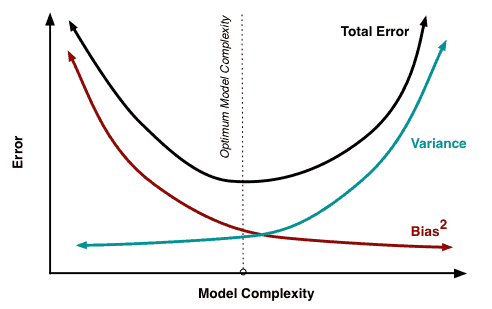

이미지 출처 [Bias-Variance Trade-Off](https://medium.com/@prabhucs01/bias-variance-trade-off-in-machine-learning-6823987a9d01)

- Total error = Bias Term + Variance + Irreducible error
    - 데이터에서 특징을 필요 이상으로 추출할 경우 분산(Variance)이 높아지고
    - 반대로 필요 이하로 추출할 경우 편향(bias)이 높아짐
- 에러율이 가장 적은 모델, 즉 최적의 모델은 분산과 편향이 균형된 모델일 것
    - 편향을 줄이면(훈련 세트 성능 높임) -> 분산이 커짐(검증세트와 성능 차이 커짐)

- **과소적합**은 너무 간단한 모델이 선택되는 것
    - 데이터의 면면과 다양성을 잡아내지 못하고, 훈련 세트에도 잘 맞지 않음
    - 따라서 과소적합에 대한 킥은 - 데이터를 더 넣고 돌려봐
    
- **과대적합**은 가진 정보를 모두 사용해서 너무 복잡한 모델을 만드는 것
    - 모델이 훈련 세트의 각 샘플에 너무 가깝게 맞춰져서 새로운 데이터에 일반화되기 어려움
    - 따라서 과대적합에 대한 킥은 - 네트워크 복잡도에 제한을 두어 가중치가 작은 값을 가지도록 강제함(**Regularization**)

In [15]:
#적절한 편향-분산 트레이드 오프 선택하기
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w # 그래디언트에서 페널티 항의 미분 값을 더함
                self.w -= self.lr * w_grad
                self.b -= b_grad
                self.w_history.append(self.w.copy()) #가중치를 기록
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y) + self.reg_loss())
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) >= 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    def reg_loss(self): #손실함수 계산 시 패널티 항 추가
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [16]:
#전처리한 훈련, 검증 세트 이용하여 단일층 신경망 모델 훈련하기
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

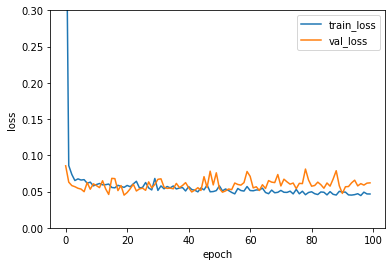

In [17]:
#손실값으로 그래프를 그린 후 에포크 횟수 지정하기
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

- 검증 손실이 대략 20번째 에포크 이후에 훈련세트보다 높아짐
- 여기까지만 훈련하고 종료(**early stopping**)

In [18]:
#훈련 조기 종료하기 (early stopping)
layer4 = SingleLayer( )
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

#최저점, 즉 과대적합 되기 전 조기 종료하여 0.967 -> 0.978

0.978021978021978

### 과대적합 규제 방법

#### 1. Early Stopping

#### 2. 가중치 규제(L1, L2 규제)


- **정형화** (Regularization)
    - 모델의 복잡도에 패널티를 부는 방법을 정규화라 함. 과적합을 방지하는 데 도움
        - 손실함수의 비용 텀에 패널티를 추가함
        - 패널티 텀에 따라 w의 크기가 변하고, 이에 따라 함수 형태의 단순화 정도가 결정됨
    - 즉 복잡할 수 있는 모델의 유연성을 어느 정도 감소시켜주는 역할
    - L1 정형화, L2 정형화, Drop out, Early stopping

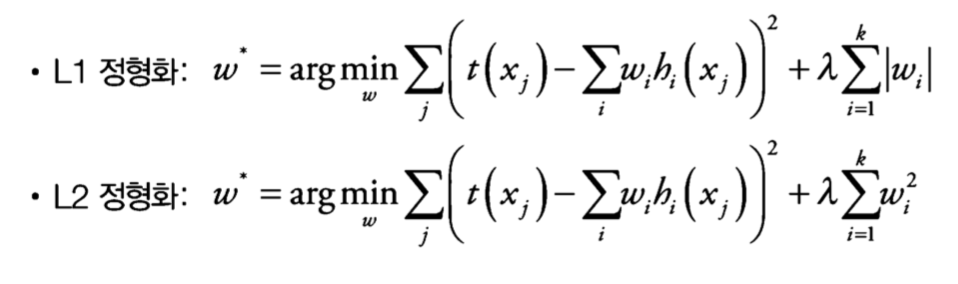

- 평균제곱오차 + 정형화 식 (람다 x 변수의(절대값 또는 제곱의) 합) (즉 L1 or L2 패널티)
- 작은 w 값으로 데이터와 예측값의 오차를 줄이는 것이 목표
    - w가 작아지면서 함수 형태가 단순화됨 -> 오버피팅의 정도 감소
    - 람다가 너무 크면 w가 너무 작아져서 함수 형태가 지나치게 단순화 -> 언더피팅 발생
    - => 적절한 람다 값의 설정이 필요

- **L1 정형화**
    - 가중치의 절대값 합에 비례하여 가중치에 패널티를 주는 정규화 유형
    - **sparse feature**에 의존하는 모델에서 L1 정규화는 관련성이 없거나 매우 낮은 특성의 가중치를 정확히 0으로 만들어 해당 피처를 모델이 무시하도록 함 (**feature selection** 효과)
    - w_grad += alpha * np.sign(w)
    
    
- **L2 정형화**
    - 가중치의 제곱의 합에 비례하여 가중치에 패널티를 주는 정규화 유형
    - 높은 긍정값 또는 낮은 부정값을 갖는 이상적 가중치를 0에 가깝게 유도함
    - 선형 모델의 일반화를 항상 개선함
    - w_grad += alpha * w
    
    
- 모델 학습 시 L1과 L2 모두를 사용할 수도 있음 (일래스틱 정형화(elastic regulation))


#### 3. Data Augumentation

    - 데이터를 늘리는 작업, 기존 데이터의 정보량을 보존한 상태로 노이즈를 줌 (내가 가진 정보량은 변하지 않음)
    - 단지 정보량에 약간의 변화를 주는 것, 데이터의 강력하게 표현되는 고유의 특징을 느슨하게 만들어냄 -> 과대적합 막을 수 있고, 예측 범위를 약간 넓힐 수 있음
        - 과대적합을 해결하기 위한 Regularization, Normalizaion -> 편향을 조금 죽이는 정도에 그침
        - 학습의 방향성을 넓히는 방법을 고민 -> 적당한 힘으로 학습 면적을 아주 조금 골고루 넓히자
        - 고유 정보가 학습될 때 해당 정보가 맵핑된 공간의 영역이 조금 넓어지면서 동시에 크게 벗어나지 않도록 학습하게 됨

#### 4. Dropout

    - 단일 경사 스텝이 일어날 때마다 특정 네트워크 레이어의 유닛을 고정된 개수만큼 무작위로 선택하여 삭제함
    - 즉 네트워크 층에 드롭아웃을 적용하여 훈련하는 동안 무작위로 층의 일부 출력 특성을 제외시킴
    - 드롭아웃하는 유닛이 많을수록 정규화가 강력한 것
    - 네트워크를 학습시켜 더 작은 네트워크로 이루어진 대규모 앙상블(여러 모델의 예측을 병합한 결과)을 모방하도록 하는 방식과 유사
    - 신경망을 학습시키는 데 유용한 정규화 형태임

#### 5. 배치 정규화

    - 가중치의 초기값을 적절히 설정하면 각 층의 활성화 값 분포가 적당히 퍼지면서 학습이 원활하게 수행되는데, 이 점에 착안하여 각 층의 활성화 값을 강제로 퍼뜨리는 것을 말함
    - 일반적으로 신경망 모델에 데이터를 입력하기 전 전체 데이터 세트를 정규화하지만, 배치 정규화는 미니 배치 별로 학습 바로 전에 데이터를 정규화하는 방식임
    - 학습 속도를 빠르게 하고, 매개변수의 초기값에 크게 의존하지 않으며, 과대적합을 억제함
    - 기본적으로 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화 함

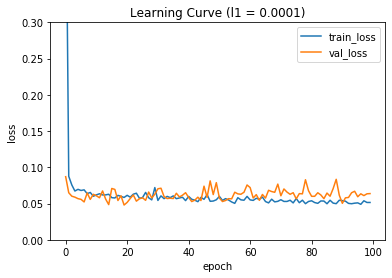

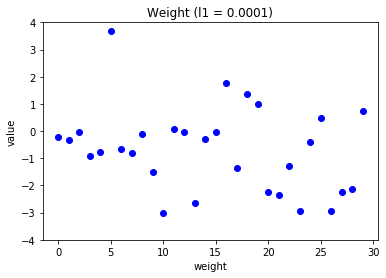

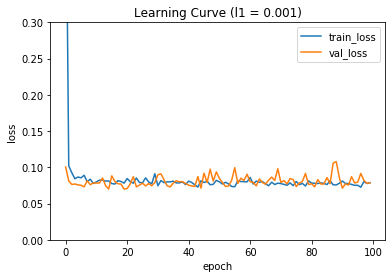

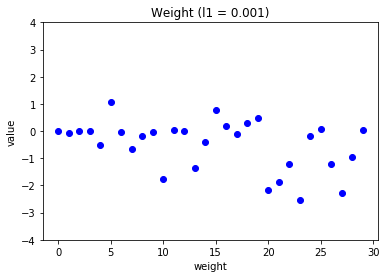

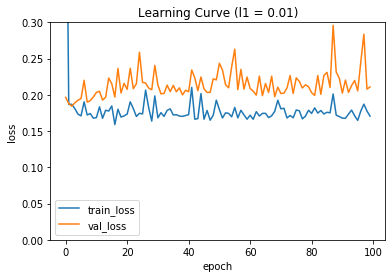

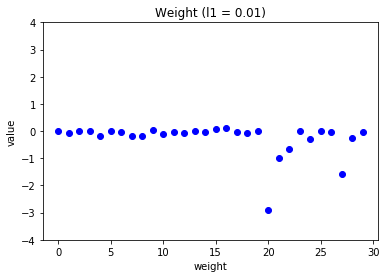

In [19]:
#L1 규제 적용
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1 = l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l1 = {})'.format(l1))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1 = {})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4,4)
    plt.show()

-> Learning Curve 그래프와 Weight 그래프를 살필 때
- 규제 강도인 L1의 값이 커질수록 훈련 세트의 손실과 검증세트의 손실이 모두 높아짐 - 과소적합 현상
- 가중치 그래프를 통해 L1의 값이 커질수록 값이 0에 가까워짐을 알 수 있음
- 가장 적절한 L1 하이퍼파라미터 값은 0.01 정도

In [20]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

-> 결과는 규제 적용하지 않고 검증세트로 성능 평가했을 때와 동일
- 데이터 세트가 작기 때문에 규제 효과가 크게 나타나지 않은 것

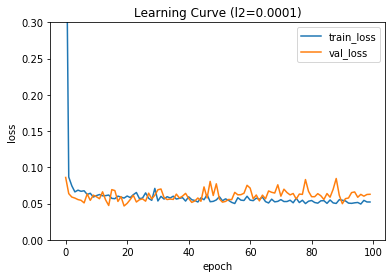

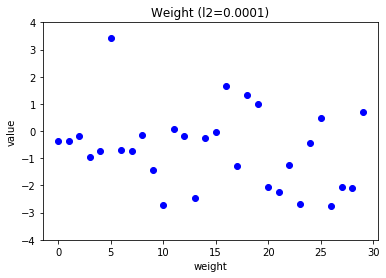

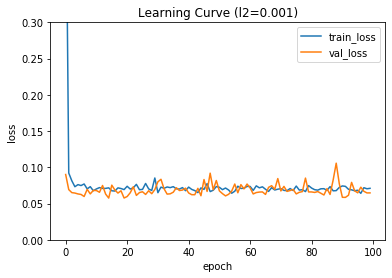

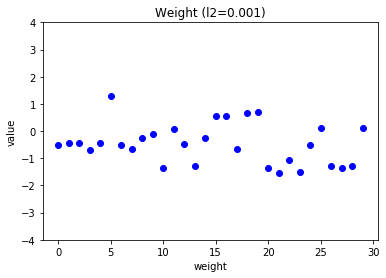

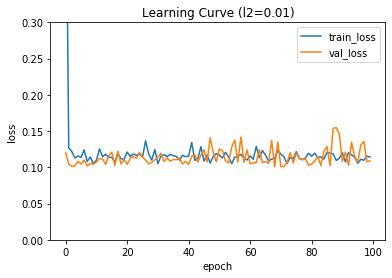

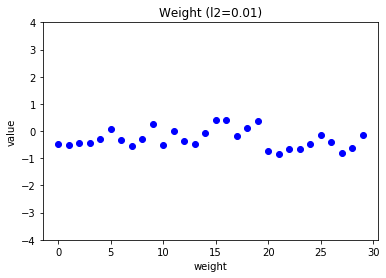

In [21]:
#L2 규제 적용
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title('Learning Curve (l2={})'.format(l2))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

-> L2 또한 L1과 비슷한 양상
- 그러나 규제 강도인 L2의 값이 커져도 과소적합이 L1만큼 심해지지는 x
- 가중치 그래프도 0에 너무 가깝게 줄어들지 x

In [22]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

-> 결과가 L1규제와 동일
- 데이터 세트의 샘플 개수가 아주 적기 때문

In [23]:
np.sum(layer6.predict(x_val_scaled) == y_val)

89

-> 91개 검증 샘플 중 89개 샘플을 올바르게 예측함!

In [24]:
#SGDClassifier에서 규제 사용하기
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

사이킷런에는 SGDClassifier 클래스 외에도 L1 규제와 L2 규제를 지원하는 모델 많음
- 예를들어 LogisticRegression, SVC, LinearSVC 클래스 등
- 이 클래스들은 패널티 항 대신 주 손실 함수의 크기를 조절하기 위해 하이퍼파라미터 c를 곱해줌
    - c는 alpha와 반대 역할, c가 커지면 규제가 줄어들고 c가 작으면 규제가 강해짐

#### 6. 교차 검증

- 전체 데이터 세트의 샘플 개수가 적어 훈련시킬 데이터가 부족할 때 과적합을 피하기 위해 사용함
- k-fold 교차 검증
    - 데이터를 k개의 data fold로 나누고 train data / test data를 나누어 검증하는 방법

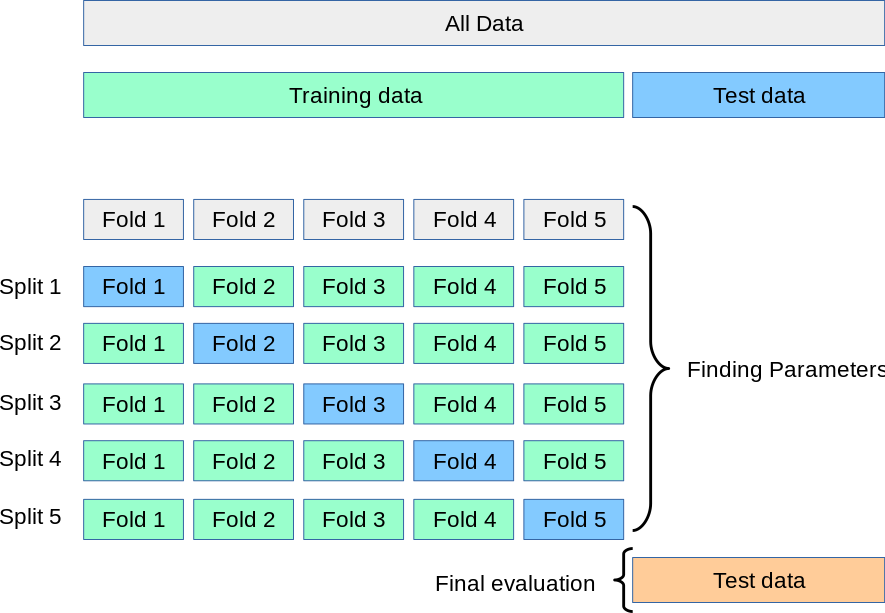
이미지 출처 [사이킷런 공식문서](https://scikit-learn.org/stable/modules/cross_validation.html)

- 8:2로 나눈 다음 8에 해당하는 훈련세트를 다시 5 덩어리로 나눔
- 작은 덩어리를 한 번씩 검증에 사용 -> 이후 나머지 덩어리를 훈련에 사용
- => 모든 훈련 세트가 평가에 1번씩 사용되므로 검증 점수가 안정적임, 또한 기존보다 더 많은 데이터로 훈련 가능
    - k=10의 경우, 10개의 폴드가 생기므로 90% 샘플을 훈련에 사용함
    - 기존의 6:2:2와 비교하면 30% 더 많은 데이터로 훈련 가능

In [25]:
#k-fold 교차 검증 구현
validation_scores = [] #성능 점수 리스트
k = 10
bins = len(x_train_all) // k

for i in range(k):
    start = i*bins
    end = (i+1)*bins
    val_fold = x_train_all[start:end] #검증 fold 샘플의 시작과 끝 인덱스, 나머지가 훈련 fold 샘플의 인덱스
    val_target = y_train_all[start:end]
    
    train_index = list(range(0, start))+list(range(end, len(x_train))) #훈련 fold의 인덱스를 모아둠
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    #훈련 데이터의 표준화 전처리를 fold를 나눈 후에 수행함
    #만약 폴드를 나누기 전에 전체 훈련 데이터를 전처리 함다면 검증 폴드의 정보를 누설하는 셈일 것
    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)

print(np.mean(validation_scores))

0.9711111111111113


In [26]:
#사이킷런의 함수 사용하여 교차 검증 수행
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10) #cv는 교차 검증을 수행할 fold 수
print(np.mean(scores['test_score']))

0.850096618357488


-> 표준화 전처리를 수행하기 때문에 정확도가 낮음

In [27]:
#전처리 단계를 포함하여 교차 검증 수행
#사이킷런의 pipeline 클래스 -> 검증 fold가 전처리 단계에서 누설되지 않도록 전처리 단계와 모델 클래스를 하나로 연결해줌
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [28]:
print(np.mean(scores['train_score'])) #return_train_score=True #훈련 fold의 점수도 얻을 수 있음

0.9875478561631581
